# (사전 작업) 데이터셋 저장 경로
- ## 데이터셋 다운로드 링크: 
 https://drive.google.com/file/d/1esChXRvooT7VBYsPqaYFhx-_NcodY_S4/view?usp=drive_link
- ## 다운 받은 압축파일을 본 노트북파일과 같은 폴더에서 압축 해제

# (클래스) 개별 종목 객체 생성: 티커명
- ### 입력: 블룸버그 데이터셋 기준 티커심볼, 시장이름('KOSPI200', 'RUSSELL3000') 
- ### 주요 메소드 기능: 해당기업 데이터셋 출력 기능

In [5]:
class Stock:
    def __init__(self, ticker, market):
        self.ticker = ticker
        self.market = market
        self.df = self.df()
    
    def df(self):
        folder_path = f'./datasets-{self.market}/'
        self.df = pd.read_csv(folder_path+ f'dataset-{self.market}-{self.ticker}.csv', ) 
        return self.df

# (클래스) 타임렉 상관관계 분석을 위한 두 기업 Pair 객체 생성
- ### 입력: target 기업 클래스 객체, source 기업 클래스 객체, 비교 구간   
- ### 본 프로젝트에서 통상적으로 target 기업은 KOSPI200의 기업, source 기업은 RUSSELL3000의 기업
- ### 주요 메소드 기능:
    - 타임렉 설정 기능
    - 특정 타임렉 상관관계 딕셔너리 출력 기능 
    - 최대 상관관계 타임렉 결과 츨력 기능 
    - 상관관계값 시각화 기능
    - 타임렉에 따른 정규화된 주가 추이 시각화 기능

In [305]:
import pandas as pd
from scipy.stats import pearsonr 
import matplotlib.pyplot as plt

class Pair:
    def __init__(self, Stock_target, Stock_source, period=75):
        self.source = Stock_source 
        self.target = Stock_target
        self.period = period # period = 75; 1 quarter
        self.returns_target = None
        self.returns_source = None
        
    def lag(self, lag):
        self._lag = lag
        r_target = self.target.df[['date', 'CHG_PCT_1D']]
        r_source = self.source.df[['date', 'CHG_PCT_1D']]
        df_merge = r_target.merge(r_source, on='date', how='outer')
        df_nonan = df_merge.sort_values('date').fillna(0)
        self.returns_target = df_nonan['CHG_PCT_1D_x'].iloc[-self.period:]
        start = -(self.period+self._lag)
        end = None if self._lag == 0 else -self._lag
        self.returns_source = df_nonan['CHG_PCT_1D_y'].iloc[start:end]
        return self
        
    def corr(self):
        self._corr, self.p_value = pearsonr(self.returns_target, self.returns_source)
        return {'source': self.source.ticker, 'target': self.target.ticker, 'lag': self._lag, 'corr': self._corr, 'p_value': self.p_value}
    
    def compare_plot(self):
        df_compare = pd.DataFrame()
        df_compare['target'] = [0] + self.returns_target.tolist()
        df_compare['source'] = [0] + self.returns_source.tolist()
        df_compare.reset_index(inplace=True)
        df_compare['normed_price_target'] = (1 + df_compare['target'] / 100).cumprod()
        df_compare['normed_price_source'] = (1 + df_compare['source'] / 100).cumprod()
        plt.plot(df_compare.index, df_compare['normed_price_target'], label='target')
        plt.plot(df_compare.index, df_compare['normed_price_source'], label=f'lagged {self._lag} source')
        plt.xlabel('index')
        plt.ylabel('normed price')
        plt.title(f'Price: {self.target.ticker} vs. lagged {self._lag} {self.source.ticker}')
        plt.legend()
        plt.show()
        self.df_compare = df_compare
    
    def result(self):
        bucket = []
        for i in range(self.period):
            dictCorr = self.lag(i).corr()
            bucket.append(dictCorr)
        self.df_result = pd.DataFrame(bucket)
        return self.df_result
        
    def stat_plot(self):
        fig, axes = plt.subplots(2, 1, figsize=(8, 10))

        # 첫 번째 플롯 그리기
        axes[0].plot(self.df_result['lag'], self.df_result['corr'], color='red')
        axes[0].set_xlabel('time lag')
        axes[0].set_ylabel('correlation')
        axes[0].set_title(f'Corr by lag: source({self.source.ticker}) -> target({self.target.ticker})')

        max_corr = self.df_result['corr'].max()
        min_corr = self.df_result['corr'].min()
        axes[0].annotate(f'Max: {max_corr:.2f}', xy=(self.df_result['lag'].iloc[self.df_result['corr'].idxmax()], max_corr),
                         xytext=(5, 0), textcoords='offset points', color='red')
        axes[0].annotate(f'Min: {min_corr:.2f}', xy=(self.df_result['lag'].iloc[self.df_result['corr'].idxmin()], min_corr),
                         xytext=(5, -10), textcoords='offset points', color='blue')

        mean_corr = self.df_result['corr'].mean()
        axes[0].axhline(mean_corr, color='red', linestyle='dashed', linewidth=0.5)
        axes[0].annotate(f'Mean: {mean_corr:.2f}', xy=(0, mean_corr),
                     xytext=(5, 0), textcoords='offset points', color='gray')
        
        # 두 번째 플롯 그리기
        axes[1].plot(self.df_result['lag'], self.df_result['p_value'], color='gray')
        axes[1].set_xlabel('time lag')
        axes[1].set_ylabel('p-value')
        axes[1].set_title(f'p-value by lag: source({self.source.ticker}) -> target({self.target.ticker})')

        mean_corr = self.df_result['p_value'].mean()
        axes[1].axhline(mean_corr, color='gray', linestyle='dashed', linewidth=0.5)
        axes[1].annotate(f'Mean: {mean_corr:.2f}', xy=(0, mean_corr),
                     xytext=(5, 0), textcoords='offset points', color='gray')
        
        max_p = self.df_result['p_value'].max()
        min_p = self.df_result['p_value'].min()
        axes[1].annotate(f'Min: {min_p:.2f}', xy=(self.df_result['lag'].iloc[self.df_result['p_value'].idxmin()], min_p),
                         xytext=(5, -10), textcoords='offset points', color='blue')

        plt.tight_layout()
        plt.show()


# (STEP1) 필요 클래스 생성

## 분석하고자 하는 종목 Stock 객체 2개: "target stock", "source stock"

In [306]:
stock_k = Stock('000080 KS', 'KOSPI200')
stock_r = Stock('BAH UN', 'RUSSELL3000')

## 분석을 위한 Pair 클래스 객체

In [307]:
pair_test = Pair(stock_k, stock_r)

## (메소드 기능구현 예시) 종목 객체의 데이터프레임 조회

In [308]:
stock_k.df

,date,PX_OPEN,PX_LOW,PX_HIGH,PX_LAST,VOLUME,MOV_AVG_5D,CHG_PCT_1D
0,2015-01-02,23100.0,22350.0,23100.0,22600.0,184419.0,23750.0,-2.7957
1,2015-01-05,22600.0,22400.0,23150.0,23050.0,170602.0,23430.0,1.9912
2,2015-01-06,22750.0,22550.0,23100.0,22650.0,142141.0,22980.0,-1.7354
3,2015-01-07,22650.0,22350.0,23050.0,22700.0,159007.0,22850.0,0.2208
4,2015-01-08,22600.0,22600.0,23100.0,22850.0,126066.0,22770.0,0.6608
...,...,...,...,...,...,...,...,...
2068,2023-05-26,23700.0,23350.0,23850.0,23450.0,267538.0,23740.0,-1.0549
2069,2023-05-30,23700.0,22900.0,23750.0,23000.0,412668.0,23560.0,-1.9190
2070,2023-05-31,23050.0,22900.0,23400.0,22900.0,329872.0,23380.0,-0.4348
2071,2023-06-01,22900.0,22500.0,22950.0,22500.0,319230.0,23110.0,-1.7467


## (메소드 기능구현 예시) 분석 대상 종목에 time lag을 설정

In [309]:
pair_test.lag(0)

In [310]:
pair_test.lag(70)

## (메소드 기능구현 예시) 설정된 time lag에 대해 두 종목의 주가 추이 비교

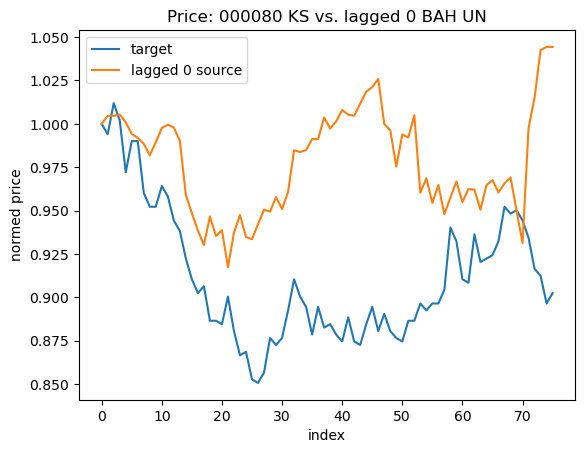

In [311]:
pair_test.lag(0).compare_plot()

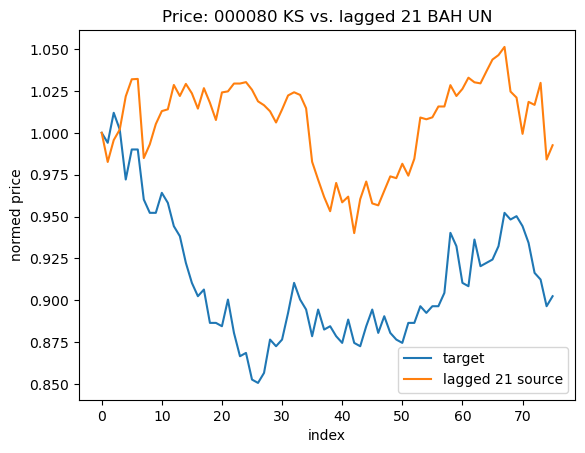

In [312]:
pair_test.lag(21).compare_plot()

In [313]:
pair_test.df_compare

,index,target,source,normed_price_target,normed_price_source
0,0,0.0000,0.0000,1.000000,1.000000
1,1,-0.5976,-1.7419,0.994024,0.982581
2,2,1.8036,1.3296,1.011952,0.995645
3,3,-0.9843,0.6294,1.001992,1.001912
4,4,-2.9821,1.9824,0.972111,1.021774
...,...,...,...,...,...
71,71,-1.0549,1.9131,0.934265,1.018478
72,72,-1.9190,-0.1773,0.916337,1.016672
73,73,-0.4348,1.2954,0.912353,1.029842
74,74,-1.7467,-4.4451,0.896417,0.984064


## (메소드 기능구현 예시) time lag 설정 후 time lag된 source의 기간 수익률 추이와 현시점 target의 기간 수익률 상관관계 정보 출력

- ### time lag = 0, 동일 시점에서의 correlation 구하기

In [315]:
pair_test.lag(0).corr()

{'source': 'BAH UN',
 'target': '000080 KS',
 'lag': 0,
 'corr': -0.08628958474868907,
 'p_value': 0.46166199630428234}

- ### time lag = 21, 'source의 과거 21일 전의 기간 수익률'과 '현시점 target의 기간 수익률' 사이의 correlation 구하기  

In [316]:
pair_test.lag(21).corr()

{'source': 'BAH UN',
 'target': '000080 KS',
 'lag': 21,
 'corr': 0.285567227272128,
 'p_value': 0.013009943800526112}

# (STEP2) 설정 범위 기간 전부에 대해 time lag에 따른 상관관계 정보 한꺼번에 출력하기

- ### 위의 time lag 설정 후 개별 correlation은 세부 기능 예시일뿐, 
- ### 실제로는 메소드 pair.result()를 실행하면 모든 time lag에 대한 상관관계 정보를 한꺼번에 얻을 수 있다. 

In [317]:
pair_test.result()

,source,target,lag,corr,p_value
0,BAH UN,000080 KS,0,-0.086290,0.461662
1,BAH UN,000080 KS,1,0.046023,0.694997
2,BAH UN,000080 KS,2,-0.019130,0.870592
3,BAH UN,000080 KS,3,-0.014615,0.900956
4,BAH UN,000080 KS,4,0.044210,0.706451
...,...,...,...,...,...
70,BAH UN,000080 KS,70,0.069448,0.553816
71,BAH UN,000080 KS,71,-0.076048,0.516677
72,BAH UN,000080 KS,72,-0.232154,0.045047
73,BAH UN,000080 KS,73,0.088679,0.449302


# (STEP3) 상관관계가 최대가 되는 time lag의 통계적 유의성 시각화

- ### 메소드 pair.stat_plot()을 실행하면 correlation 최대가 되는 time lag 지점을 시각적으로 확인할 수 있고, 
- ### 해당 correlation에서의 p-value로 correlation의 통계적 유의성을 확인할 수 있다.

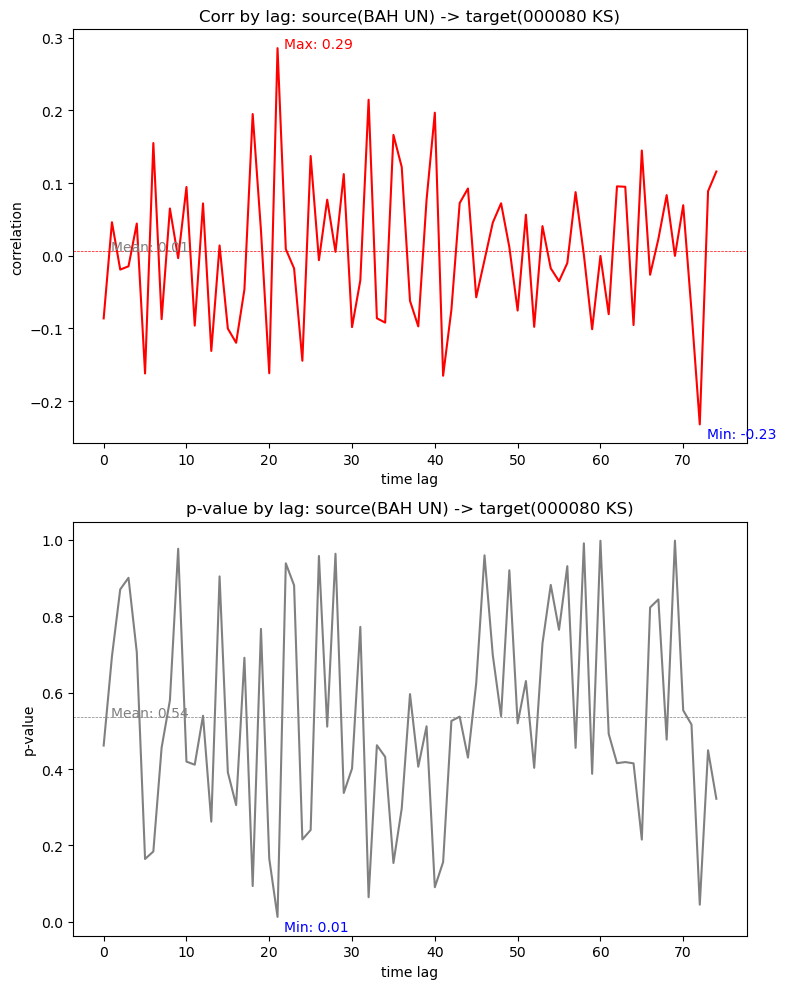

In [319]:
pair_test.stat_plot()

### (출력 예시) 상관관계가 최대인 time lag 확인과 통계적 유의성 확인

In [320]:
pair_test.result().iloc[20:23]

,source,target,lag,corr,p_value
20,BAH UN,000080 KS,20,-0.161740,0.165647
21,BAH UN,000080 KS,21,0.285567,0.013010
22,BAH UN,000080 KS,22,0.009009,0.938851


In [321]:
pair_test.result().iloc[71:74]

,source,target,lag,corr,p_value
71,BAH UN,000080 KS,71,-0.076048,0.516677
72,BAH UN,000080 KS,72,-0.232154,0.045047
73,BAH UN,000080 KS,73,0.088679,0.449302


# (STEP4) 상관관계가 최대가 되는 time lag을 적용한 주가 추이 시각화

- ### 상관관계가 없는 time lag = 0 현시점 기준 동일 기간 단순 비교

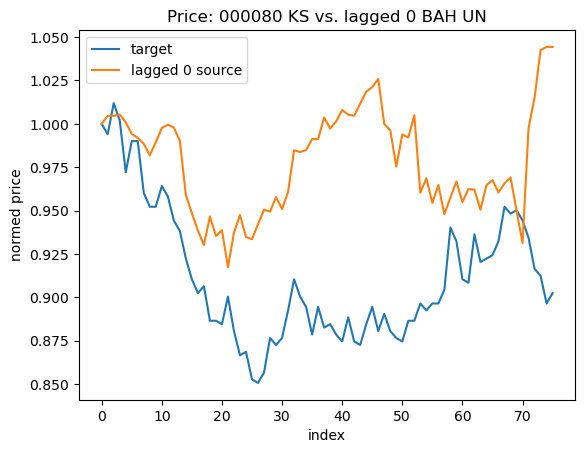

In [322]:
pair_test.lag(0).compare_plot()

- ### 상관관계가 최대인 time lag = 21 기준, lagged 21 source 와 target의 주가 추이 비교
- ### 추이의 유사도가 높아보임 
- ### 통계적/수치적 결론 (인과적/현실적 관계로 일반화는 어려울 것으로 사료됨)

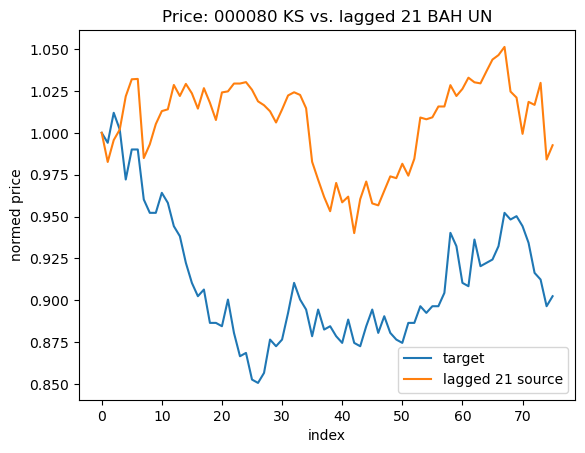

In [323]:
pair_test.lag(21).compare_plot()

In [324]:
pair_test.df_compare

,index,target,source,normed_price_target,normed_price_source
0,0,0.0000,0.0000,1.000000,1.000000
1,1,-0.5976,-1.7419,0.994024,0.982581
2,2,1.8036,1.3296,1.011952,0.995645
3,3,-0.9843,0.6294,1.001992,1.001912
4,4,-2.9821,1.9824,0.972111,1.021774
...,...,...,...,...,...
71,71,-1.0549,1.9131,0.934265,1.018478
72,72,-1.9190,-0.1773,0.916337,1.016672
73,73,-0.4348,1.2954,0.912353,1.029842
74,74,-1.7467,-4.4451,0.896417,0.984064


- ### 음의 상관관계가 최대인 time lag = 72 기준, lagged 72 source 와 target의 주가 추이 비교
- ### 통계적/수치적 결론 (인과적/현실적 관계로 일반화는 어려울 것으로 사료됨)

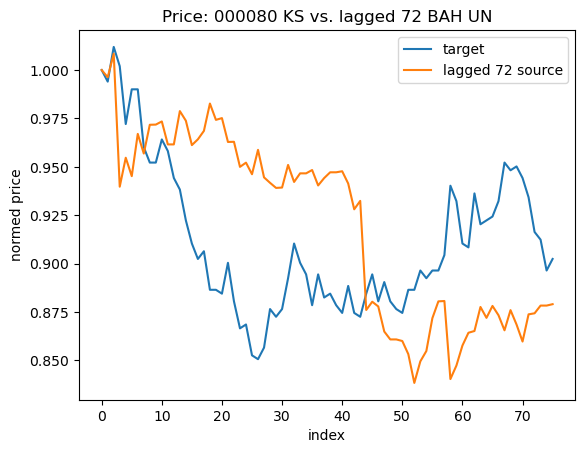

In [325]:
pair_test.lag(72).compare_plot()

# (이후 작업 개요)

- ### Market class 정의 후 모든 KOSPI200 모든 종목을 담은 객체, RUSSELL300 모든 종목을 담은 객체 생성 
- ### 위 두 Market 객체에 대해 반복 알고리즘으로 가능한 모든 종목 조합에 대해 최적의 time lag 상관관계 통계 정보 도출
- ### Portfolio class 정의 후 임의의 종목들 리스트와 비중 리스트로 포트폴리오 객체 생성 후, Pair class로 위의 분석 절차 수행- 개뱔 종목간의 상관관계 이상의 일반적인 time lag 솔루션 도출

In [326]:
# 휴장일 확인
df_concat.iloc[[11]]

,date,CHG_PCT_1D_x,CHG_PCT_1D_y
11,2015-01-19,-0.4444,NaN


In [327]:
# 휴장일 확인
df_concat.iloc[[31]]

,date,CHG_PCT_1D_x,CHG_PCT_1D_y
31,2015-02-16,-1.9481,NaN
